In [1]:
from keras.models               import Sequential
from keras.layers               import Dense, Activation, Dropout
from keras.optimizers           import SGD, Adam, Nadam         
from keras                      import callbacks
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core          import Flatten

%matplotlib inline

from matplotlib.patches         import Ellipse
import matplotlib.pyplot as plt
import numpy  as np
import random as rd
import tables as tb

Using Theano backend.
Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5105)
/home/jmbenlloch/.local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


Load Data

In [2]:
indata = tb.open_file('NEW_krypton_maps_500000.h', 'r')
x      = np.reshape(indata.root.maps,(len(indata.root.maps),1,48,48)) # for cnn
x     /= np.max(x)
y_     = np.array(indata.root.coords,dtype=np.float32)
y_    /= 198.0
y_    += 1
y_    /= 2

Setup DNN

In [3]:
model = Sequential()
#model.add(MaxPooling2D(pool_size=(2,2), input_shape=(1,48,48)))
#model.add(Convolution2D(128,3,3, border_mode='same', input_shape=(1,48,48)))
#model.add(Convolution2D(64,3,3, border_mode='same',))
model.add(Flatten(input_shape=(1,48,48)))
#model.add(Flatten())
#model.add(Dense(output_dim=1024,activation='relu')) 
model.add(Dense(output_dim=512,  activation='relu'))
model.add(Dense(output_dim=256,  activation='relu'))
model.add(Dense(output_dim=2,    activation='relu'))
#model.compile(loss='mse', optimizer=SGD(lr=0.1, momentum=0.9, nesterov=True))
#model.compile(loss='mse', optimizer=Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004))
model.compile(loss='mse', optimizer=Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004))

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
flatten_1 (Flatten)              (None, 2304)          0           flatten_input_1[0][0]            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 512)           1180160     flatten_1[0][0]                  
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 256)           131328      dense_1[0][0]                    
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 2)             514         dense_2[0][0]                    
Total params: 1312002
_____________________________________________________________________

In [4]:
ntrain = 400000
xtr    = x [:ntrain]
xv     = x [ntrain:]
ytr    = y_[:ntrain]
yv     = y_[ntrain:]
hist   = model.fit(xtr, ytr, nb_epoch=300, batch_size=2000, validation_data=(xv,yv), verbose=2, callbacks=[])

Train on 400000 samples, validate on 100000 samples
Epoch 1/300
5s - loss: 0.0621 - val_loss: 0.0032
Epoch 2/300
4s - loss: 0.0017 - val_loss: 9.5314e-04
Epoch 3/300
4s - loss: 6.1132e-04 - val_loss: 4.1045e-04
Epoch 4/300
4s - loss: 3.2111e-04 - val_loss: 2.7266e-04
Epoch 5/300
4s - loss: 2.3463e-04 - val_loss: 2.1420e-04
Epoch 6/300
4s - loss: 1.9025e-04 - val_loss: 1.7889e-04
Epoch 7/300
5s - loss: 1.6223e-04 - val_loss: 1.5621e-04
Epoch 8/300
5s - loss: 1.4469e-04 - val_loss: 1.4114e-04
Epoch 9/300
4s - loss: 1.3352e-04 - val_loss: 1.4176e-04
Epoch 10/300
4s - loss: 1.2640e-04 - val_loss: 1.2906e-04
Epoch 11/300
4s - loss: 1.2199e-04 - val_loss: 1.2255e-04
Epoch 12/300
4s - loss: 1.1886e-04 - val_loss: 1.1816e-04
Epoch 13/300
4s - loss: 1.1613e-04 - val_loss: 1.1541e-04
Epoch 14/300
4s - loss: 1.1505e-04 - val_loss: 1.1443e-04
Epoch 15/300
4s - loss: 1.1203e-04 - val_loss: 1.1541e-04
Epoch 16/300
4s - loss: 1.1085e-04 - val_loss: 1.1029e-04
Epoch 17/300
5s - loss: 1.0988e-04 - val_

In [5]:
predictions = model.predict(xv)
dist = np.sqrt((predictions[:,0] - yv[:,0])**2 + (predictions[:,1] - yv[:,1])**2) * 396
print(np.mean(dist))

0.91116


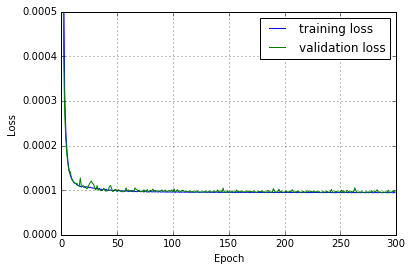

In [6]:
plt.plot(range(300), hist.history['loss'],     label='training loss')
plt.plot(range(300), hist.history['val_loss'], label='validation loss')
plt.ylim([0,.0005])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

/home/jmbenlloch/anaconda2/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/jmbenlloch/anaconda2/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


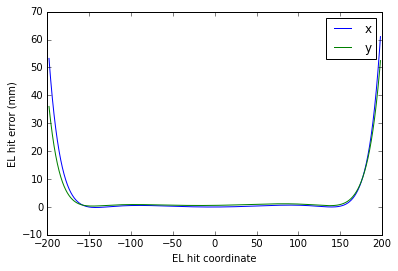

In [7]:
gpredictions = (predictions*2 - 1)*198
gyv          = (yv         *2 - 1)*198

xerr = abs(gpredictions[:,0] - gyv[:,0])
yerr = abs(gpredictions[:,1] - gyv[:,1])

# could replace these best fit lines with something average data points
# x, y error as a function of x, y  EL hit coordinate
bestfitx = plt.plot(np.unique(gyv[:,0]), np.poly1d(np.polyfit(gyv[:,0],xerr, 50))(np.unique(gyv[:,0])),label='x')
bestfitx = plt.plot(np.unique(gyv[:,1]), np.poly1d(np.polyfit(gyv[:,1],yerr, 50))(np.unique(gyv[:,1])),label='y')
plt.legend(loc='upper right')
plt.xlabel('EL hit coordinate')
plt.ylabel('EL hit error (mm)')
plt.show()

Now test model against montecarlo data (with diffusion)...